# Employee Attrition Modeling

**Data:** This analysis uses a simulated HR dataset that can be found on Kaggle [here](https://www.kaggle.com/datasets/arashnic/hr-ana?datasetId=1055354).

## Import Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("white")
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', None)  

#Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, accuracy_score, confusion_matrix, roc_auc_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier


## Data Preview
Our training data consists of ~55k rows of employee data. Our testing data consists of ~23.5k rows of employee data. We'll explore the training data and fit a model to predict who amongst the test data should be considered for promotion. 
* There are no duplicate employee IDs
* The distributions for our variables are comparable between train and test sets.
* Both the education and previous_year_rating columns have missing values that will need to be addressed.
* All columns appear to have appropriate initial data types
* All numeric columns appear to have reasonable values (no inherently improbably mins/maxs)
* The promotion rate in the training set is 8.5%

In [25]:
train = pd.read_csv('train.csv')
train.shape
train.columns
train['employee_id'].nunique()
test = pd.read_csv('test.csv')
test.shape
test.columns
test['employee_id'].nunique()



(54808, 13)

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'awards_won?', 'avg_training_score',
       'is_promoted'],
      dtype='object')

54808

(23490, 12)

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'awards_won?', 'avg_training_score'],
      dtype='object')

23490

In [26]:
train.info()
train.describe()
test.info()
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won?           54808 non-null  int64  
 11  avg_training_score    54808 non-null  int64  
 12  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.4+ MB


,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,99.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           23490 non-null  int64  
 1   department            23490 non-null  object 
 2   region                23490 non-null  object 
 3   education             22456 non-null  object 
 4   gender                23490 non-null  object 
 5   recruitment_channel   23490 non-null  object 
 6   no_of_trainings       23490 non-null  int64  
 7   age                   23490 non-null  int64  
 8   previous_year_rating  21678 non-null  float64
 9   length_of_service     23490 non-null  int64  
 10  awards_won?           23490 non-null  int64  
 11  avg_training_score    23490 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 2.2+ MB


,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score
count,23490.000000,23490.000000,23490.000000,21678.000000,23490.000000,23490.000000,23490.000000
mean,39041.399149,1.254236,34.782929,3.339146,5.810387,0.022776,63.263133
std,22640.809201,0.600910,7.679492,1.263294,4.207917,0.149191,13.411750
min,3.000000,1.000000,20.000000,1.000000,1.000000,0.000000,39.000000
25%,19370.250000,1.000000,29.000000,3.000000,3.000000,0.000000,51.000000
50%,38963.500000,1.000000,33.000000,3.000000,5.000000,0.000000,60.000000
75%,58690.000000,1.000000,39.000000,4.000000,7.000000,0.000000,76.000000
max,78295.000000,9.000000,60.000000,5.000000,34.000000,1.000000,99.000000


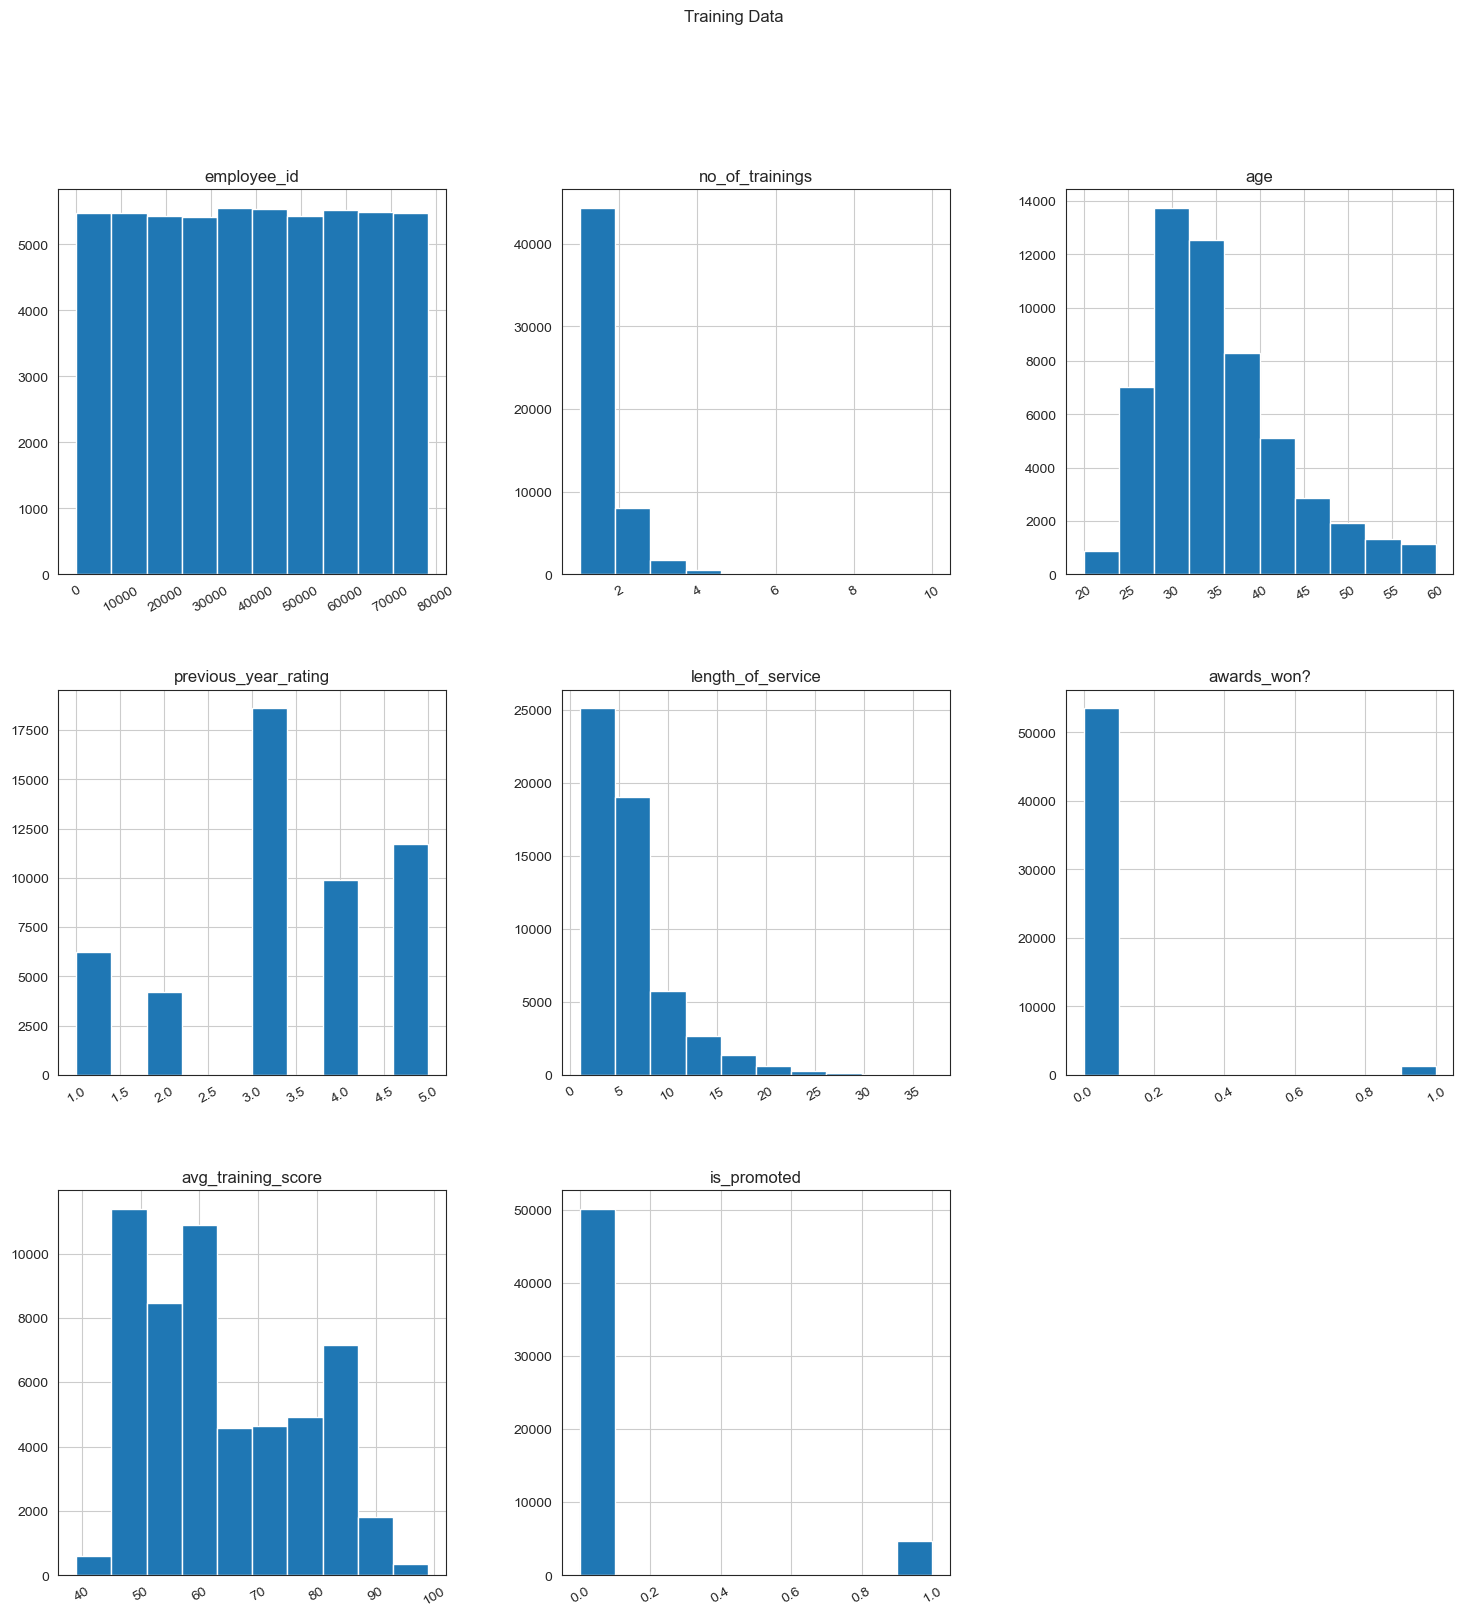

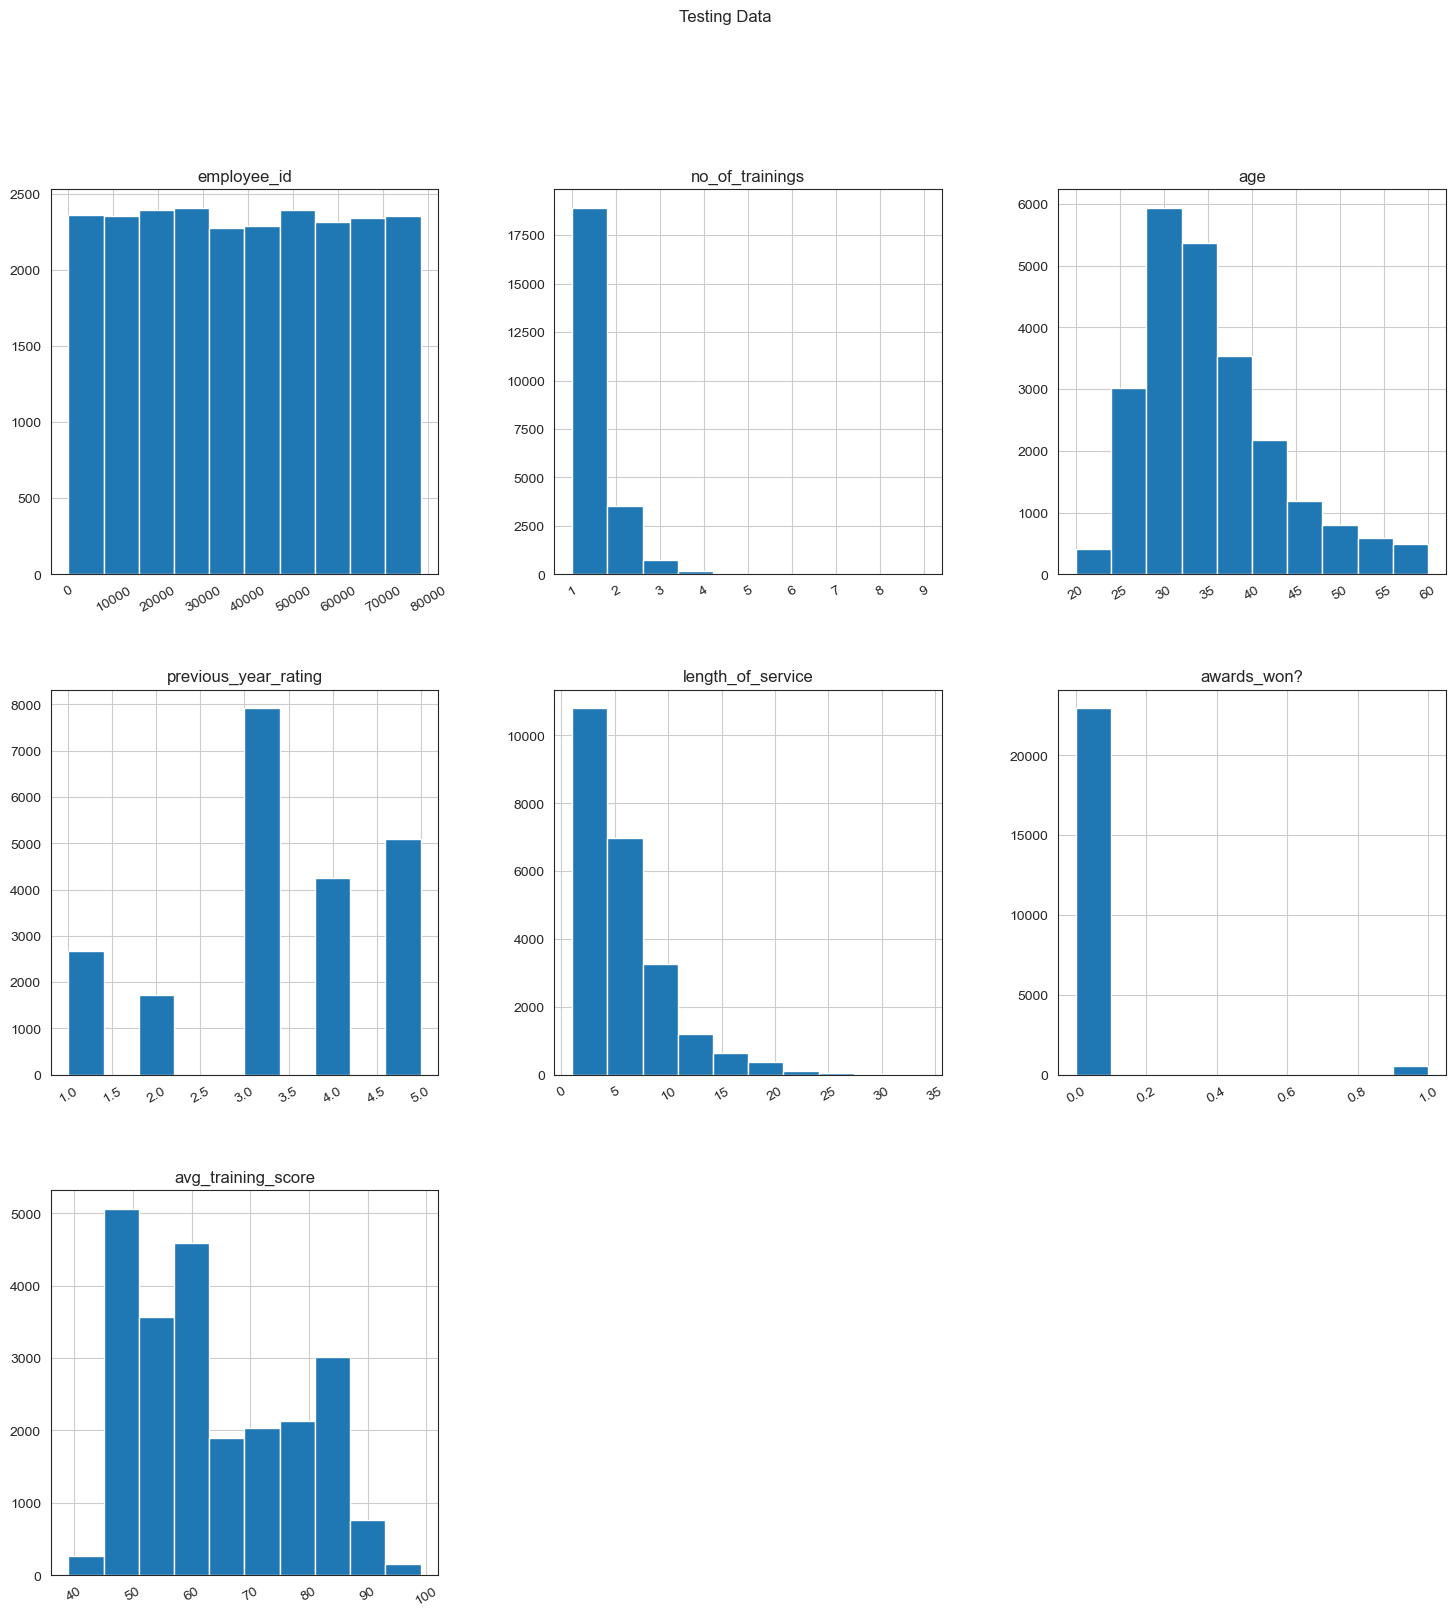

In [10]:
train.hist(figsize=(18,18), xrot=30)
plt.suptitle('Training Data')
plt.show();

test.hist(figsize=(18,18), xrot=30)
plt.suptitle('Testing Data')
plt.show();

In [13]:
#review some categorical columns
cat_cols = train.select_dtypes(include=['object']).columns

for c in cat_cols:
    train[c].value_counts(normalize = True)
    train[c].value_counts()

for c in cat_cols:
    test[c].value_counts(normalize = True)
    test[c].value_counts()

Sales & Marketing    0.307254
Operations           0.207050
Technology           0.130236
Procurement          0.130236
Analytics            0.097650
Finance              0.046271
HR                   0.044118
Legal                0.018957
R&D                  0.018227
Name: department, dtype: float64

Sales & Marketing    16840
Operations           11348
Technology            7138
Procurement           7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: department, dtype: int64

region_2     0.225204
region_22    0.117282
region_7     0.088363
region_15    0.051233
region_13    0.048314
region_26    0.041235
region_31    0.035305
region_4     0.031072
region_27    0.030269
region_16    0.026730
region_28    0.024048
region_11    0.023993
region_23    0.021438
region_29    0.018136
region_32    0.017242
region_19    0.015947
region_20    0.015509
region_14    0.015089
region_25    0.014943
region_17    0.014523
region_5     0.013976
region_6     0.012589
region_30    0.011987
region_8     0.011951
region_10    0.011823
region_1     0.011130
region_24    0.009269
region_12    0.009123
region_9     0.007663
region_21    0.007499
region_3     0.006313
region_34    0.005328
region_33    0.004908
region_18    0.000566
Name: region, dtype: float64

region_2     12343
region_22     6428
region_7      4843
region_15     2808
region_13     2648
region_26     2260
region_31     1935
region_4      1703
region_27     1659
region_16     1465
region_28     1318
region_11     1315
region_23     1175
region_29      994
region_32      945
region_19      874
region_20      850
region_14      827
region_25      819
region_17      796
region_5       766
region_6       690
region_30      657
region_8       655
region_10      648
region_1       610
region_24      508
region_12      500
region_9       420
region_21      411
region_3       346
region_34      292
region_33      269
region_18       31
Name: region, dtype: int64

Bachelor's          0.699803
Master's & above    0.284834
Below Secondary     0.015363
Name: education, dtype: float64

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

m    0.702379
f    0.297621
Name: gender, dtype: float64

m    38496
f    16312
Name: gender, dtype: int64

other       0.555503
sourcing    0.423661
referred    0.020836
Name: recruitment_channel, dtype: float64

other       30446
sourcing    23220
referred     1142
Name: recruitment_channel, dtype: int64

Sales & Marketing    0.311409
Operations           0.202810
Procurement          0.128565
Technology           0.128182
Analytics            0.098723
Finance              0.046445
HR                   0.046190
Legal                0.018944
R&D                  0.018731
Name: department, dtype: float64

Sales & Marketing    7315
Operations           4764
Procurement          3020
Technology           3011
Analytics            2319
Finance              1091
HR                   1085
Legal                 445
R&D                   440
Name: department, dtype: int64

region_2     0.225585
region_22    0.116603
region_7     0.084376
region_13    0.049681
region_15    0.048106
region_26    0.043040
region_31    0.035930
region_4     0.032993
region_27    0.030226
region_28    0.025330
region_16    0.025117
region_11    0.024308
region_23    0.021967
region_32    0.018433
region_29    0.017625
region_19    0.017454
region_17    0.015368
region_14    0.014900
region_5     0.014559
region_25    0.014347
region_20    0.013878
region_6     0.012686
region_30    0.011622
region_8     0.011452
region_10    0.011452
region_1     0.010132
region_24    0.009323
region_12    0.009153
region_9     0.007663
region_21    0.007620
region_34    0.006599
region_3     0.006258
region_33    0.005364
region_18    0.000851
Name: region, dtype: float64

region_2     5299
region_22    2739
region_7     1982
region_13    1167
region_15    1130
region_26    1011
region_31     844
region_4      775
region_27     710
region_28     595
region_16     590
region_11     571
region_23     516
region_32     433
region_29     414
region_19     410
region_17     361
region_14     350
region_5      342
region_25     337
region_20     326
region_6      298
region_30     273
region_8      269
region_10     269
region_1      238
region_24     219
region_12     215
region_9      180
region_21     179
region_34     155
region_3      147
region_33     126
region_18      20
Name: region, dtype: int64

Bachelor's          0.693712
Master's & above    0.289633
Below Secondary     0.016655
Name: education, dtype: float64

Bachelor's          15578
Master's & above     6504
Below Secondary       374
Name: education, dtype: int64

m    0.706513
f    0.293487
Name: gender, dtype: float64

m    16596
f     6894
Name: gender, dtype: int64

other       0.556748
sourcing    0.424053
referred    0.019200
Name: recruitment_channel, dtype: float64

other       13078
sourcing     9961
referred      451
Name: recruitment_channel, dtype: int64

In [27]:
#drop unnecessary columns: region (there are A LOT of them) and employee id
train.drop(['region', 'employee_id'], axis = 1, inplace = True)
test.drop(['region', 'employee_id'], axis = 1, inplace = True)


## EDA / Cleaning
First, I want to think through how to handle the missing data in the perf rating and education columns.

Performance Rating:
* People without ratings do indeed appear to be eligible for promotion, so it's not appropriate to drop them from the dataset.
* I don't want to drop this feature because I anticipate that it will be a driver of promotion.
* Since it is a low number of people with missing values and I don't have context to believe their are pre-existing patterns in perf rating, I'll impute the median value, and use the has_rating column as an additional feature to indicate missingness 


In [30]:
train['has_rating'] = train['previous_year_rating'].apply(lambda x: 0 if pd.isnull(x) else 1)

train[['has_rating', 'is_promoted']].value_counts()
train[['education', 'is_promoted']].value_counts()
#train['previous_year_rating'].unique()

has_rating  is_promoted
1           0              46355
            1               4329
0           0               3785
            1                339
dtype: int64

education         is_promoted
Bachelor's        0              33661
Master's & above  0              13454
Bachelor's        1               3008
Master's & above  1               1471
Below Secondary   0                738
                  1                 67
dtype: int64

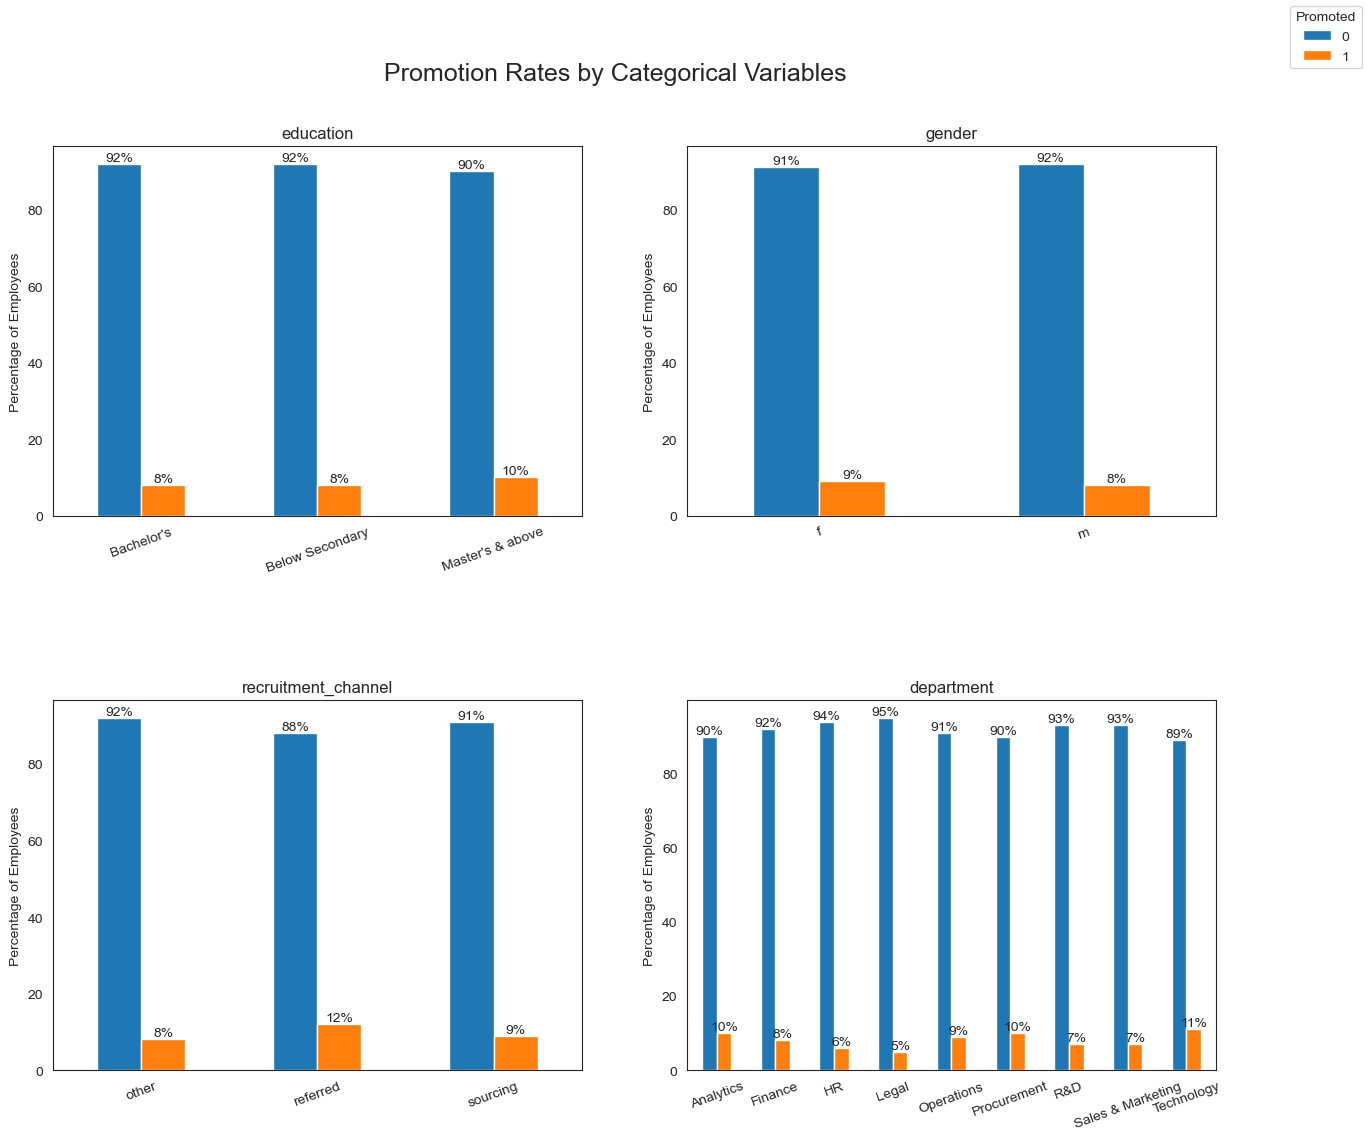

In [31]:
target_cat_cols = ['education', 'gender', 'recruitment_channel', 'department']

# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Promotion Rates by Categorical Variables", fontsize=18, y=0.95)
# create empty list to store labels for legend
labels = []

# loop through columns and axes
for col, ax in zip(target_cat_cols, axs.ravel()):
    # filter df for ticker and plot on specified axes
    # Group by variables and get proportions
    grouped_df = train.groupby([col, 'is_promoted']).size().groupby(level=0).apply(lambda x: round(x / x.sum()*100, 0)).reset_index(name='proportion')

    # Pivot table to format data for plotting
    pivot_df = grouped_df.pivot(index= col, columns='is_promoted', values='proportion')

    # Plot bar chart
    pivot_df.plot(kind='bar', rot=20, ax=ax)

    # Add value labels to bars
    for p in ax.containers:
        ax.bar_label(p, label_type='edge', labels=[f"{int(round(height))}%" for height in p.datavalues], fontsize=10)

    # Set x and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('Percentage of Employees')


    # Append the labels for this subplot to the list
    labels.append(pivot_df.columns.to_list())
    # Remove legend
    ax.legend().set_visible(False)

    # Set the title for the subplot
    ax.set_title(f"{col}")
    ax.grid(False)
    
# Flatten the list of labels and remove duplicates
flat_labels = list(set([item for sublist in labels for item in sublist]))

# Show legend at the top right of the figure
fig.legend(labels=flat_labels, loc='upper right', title='Promoted')

plt.show();

Observations:
* Promotion rates are about equal by education level, slightly higher for Master's level.
* Promotion rates are nearly equal by gender.
* Referrals have a higher promotion rate.
* HR and Legal have lower promo rates while Analytics, Procurement, and Tech have higher rates.

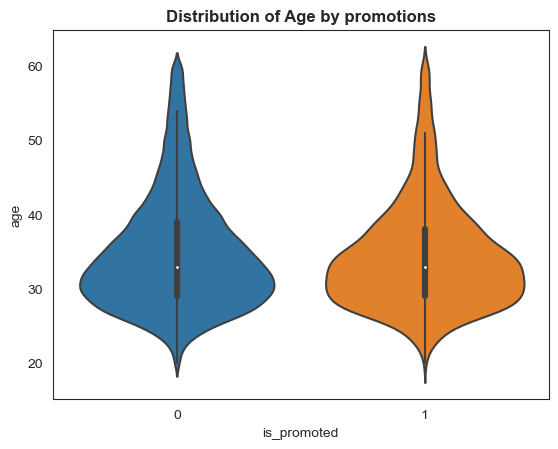

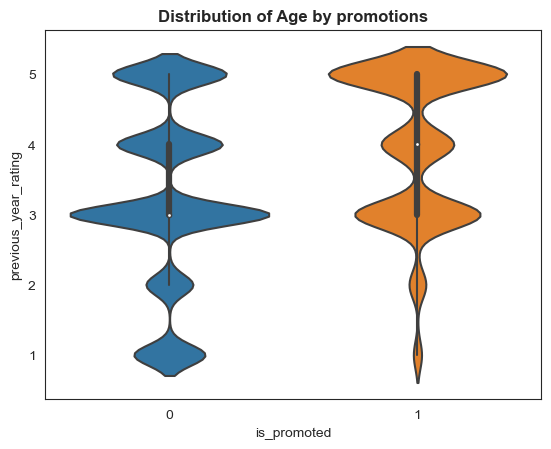

In [35]:
sns.violinplot(data= train, x = "is_promoted", y = "age", split= True)
plt.title('Distribution of Age by promotions', weight= 'bold')
plt.show();

sns.violinplot(data= train, x = "is_promoted", y = "previous_year_rating", split= True)
plt.title('Distribution of Age by promotions', weight= 'bold')
plt.show();